# Analyse ROMY Events

In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sixdegrees.sixdegrees import sixdegrees

from sixdegrees.plots.plot_waveform_cc import plot_waveform_cc
from sixdegrees.plots.plot_cwt_all import plot_cwt_all
from sixdegrees.plots.plot_velocities import plot_velocities
from sixdegrees.plots.plot_backazimuth_results import plot_backazimuth_results
from sixdegrees.plots.plot_spectra_comparison_fill import plot_spectra_comparison_fill
from sixdegrees.plots.plot_trace_dispersion import plot_trace_dispersion


## Configurations

In [ ]:
config = {
    # Required time window parameters
    'tbeg': "2023-09-08 22:13:00",  # Start time
    'tend': "2023-09-08 23:00:00",  # End time

    # Event information
    'origin_time': "2023-09-08 22:11:00",
    'magnitude': 6.8,

    # Station coordinates (required)
    'station_lon': 11.275476,  # BSPF longitude
    'station_lat': 48.162941,    # BSPF latitude
    
    # SEED identifiers
    'seed': "XX.ROMY..",     # Default seed ID
    'rot_seed': ["BW.ROMY.10.BJZ", "BW.ROMY..BJU", "BW.ROMY..BJV"], # "BW.ROMY.30.BJ*",  # Rotation sensor seed ID
    'tra_seed': ["GR.FUR..BHZ", "GR.FUR..BHN", "GR.FUR..BHE"],  # Translation sensor seed ID
    
    # Data source
    'data_source': "sds",  # "fdsn" | "sds" | "mseed_file"

    # Path to SDS for rotation and translation data
    'path_to_sds_rot': "/home/andbro/freenas/romy_archive/",    # SDS path for rotation data
    'path_to_sds_tra': "/home/andbro/bay200/mseed_online/archive/",  # SDS path for translation data

    # Path to inventory of rotation and translation sensor
    'path_to_inv_rot': "./metadata/station_BW_ROMY.xml",  # Rotation station inventory
    'path_to_inv_tra': "./metadata/station_GR_FUR.xml",  # Translation station inventory
    
    # Path configurations
    'workdir': "./",            # Working directory
    'path_to_data_out': "./output/",  # Output directory

    # Set rotation of components
    'rotate_zne': True,

    # Rotate ROMY components
    'use_romy_zne': True,

    # Remove responses
    'tra_remove_response': True,
    'rot_remove_response': True,

    # Project information
    'project': "ROMY_Analysis",  # Project name

    # Optional parameters
    'verbose': True,            # Print detailed information
}

Store configurations as Yaml File

In [3]:
filename = f"{config['tbeg'][:10].replace('-','')}_M{str(config['magnitude']).replace('.','')}"

sixdegrees.store_as_yaml(config, "./config/"+filename)

 -> file ./config/20230908_M68.yml already exists. Aborting...


Setup a sixdegrees object

In [4]:
sd = sixdegrees(conf=config)

Store the configuration as a pickle or yaml file

In [ ]:
# sd.store_as_pickle(config, "./"+f"testname")
# sd.store_as_yaml(config, "./"+f"testname")

Get key information about the event

In [19]:
try:
    ev = sd.get_event_info(
        origin_time=config['origin_time'],
        base_catalog="USGS",
        magnitude=config['magnitude']
    )
except:
    print("No event found")
    ev = {
        "backazimuth": 0,
        "distance_km": 0,
        "origin_time": config['origin_time'],
        "magnitude": config['magnitude']
    }

Found event:
Origin time: 2023-09-08T22:11:01.405000Z
Magnitude: 6.8 mww
Location: 31.058°N, -8.385°E
Depth: 19.0 km
Epicentral Distance: 2526.01 km
Epicentral Distance: 22.7°
Backazimuth: 228.40°


This will load the data from the data source:
- local mseed file
- local sds system
- fdsn (online)

and trim it to the time window

In [7]:
sd.load_data(config['tbeg'], config['tend'])

-> fetching GR.FUR..BHZ data from SDS
-> fetching GR.FUR..BHN data from SDS
-> fetching GR.FUR..BHE data from SDS
-> translation inventory provided: ./metadata/station_GR_FUR.xml
-> removing response: ACC
-> rotating translational data ZNE to ZNE
3 Trace(s) in Stream:
GR.FUR..BHZ | 2023-09-08T22:12:58.990000Z - 2023-09-08T23:00:00.990000Z | 20.0 Hz, 56441 samples
GR.FUR..BHN | 2023-09-08T22:12:58.990000Z - 2023-09-08T23:00:00.990000Z | 20.0 Hz, 56441 samples
GR.FUR..BHE | 2023-09-08T22:12:58.989999Z - 2023-09-08T23:00:00.989999Z | 20.0 Hz, 56441 samples
-> fetching BW.ROMY.10.BJZ data from SDS
-> fetching BW.ROMY..BJU data from SDS
-> fetching BW.ROMY..BJV data from SDS
-> rotation inventory provided: ./metadata/station_BW_ROMY.xml
-> removing sensitivity
-> rotated ROMY data using rotate_romy_zne (keep_z=True)
3 Trace(s) in Stream:
BW.ROMY..BJZ | 2023-09-08T22:12:59.011600Z - 2023-09-08T23:00:01.011600Z | 20.0 Hz, 56441 samples
BW.ROMY..BJN | 2023-09-08T22:12:58.999399Z - 2023-09-08T2

Ensure that all traces of stream have the same sample size

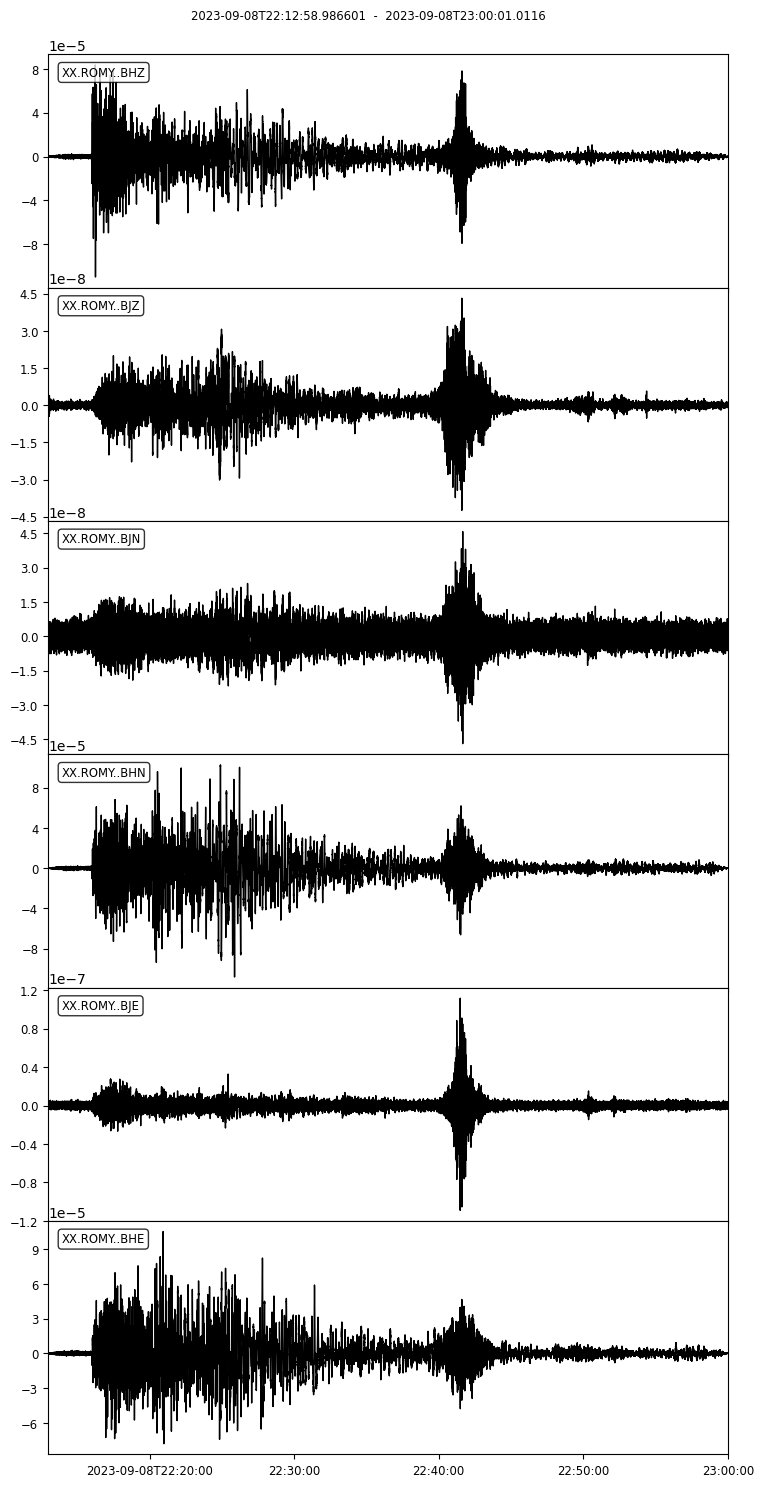

In [8]:
sd.st.plot(equal_scale=False);

Ensure that all traces have the same size.

In [9]:
sd.trim_stream(set_common=True, set_interpolate=False)

### Write data to file or SDS system

If required, the data can be written to a .mseed file or a SDS type file archive

In [10]:
# write to mseed file
# sd.st.write(f"./data/romy_eventM{config['magnitude']}.mseed", format="MSEED")

# write to sds filesystem
# sd.write_to_sds(sd.st, "./data/", format="MSEED")

## Analysis

Define a set of parameters for the analysis.

In [ ]:
params = {
    # frequency band
    "fmin": 0.01,
    "fmax": 0.1,

    # backazimuth steps
    "baz_step": 1,

    # time window
    "twin_sec": 50.0,
    "twin_overlap": 0.5,

    # threshold for cross-correlation coefficient
    "cc_threshold": 0.8,
}

### Wavelet Comparsion

In [24]:
# First compute CWT for all components
cwt_results = {}
for comp in ['Z', 'N', 'E']:

    try:
        # Rotation components
        rot_data = sd.get_stream("rotation").select(channel=f"*{comp}")[0]
        cwt_results[f"{comp}_Rotation"] = sd.compute_cwt(
            rot_data.times(), rot_data.data, rot_data.stats.delta,
            normalize=True
        )
    except:
        print(f"No {comp} data for rotation")
    try:
        # Translation components
        acc_data = sd.get_stream("translation").select(channel=f"*{comp}")[0]
        cwt_results[f"{comp}_Translation"] = sd.compute_cwt(
            acc_data.times(), acc_data.data, acc_data.stats.delta,
            normalize=True
        )
    except:
        print(f"No {comp} data for ranslation")


In [ ]:
# Then plot all components
fig = plot_cwt_all(
    rot=sd.get_stream("rotation"),
    acc=sd.get_stream("translation"),
    cwt_output=cwt_results,
    clog=True,
    ylim=1
)

Frequency band to filter (this is applied to the stream object after being reset to raw stream)

In [12]:
sd.filter_data(fmin=params['fmin'], fmax=params['fmax'], output=False)

Apply polarity correction if needed. This is applied to the stream object that is processed. If raw is True, the polarity correction is applied to the raw stream too.

In [13]:
sd.polarity_stream(pol_dict={"HZ": -1, "JZ": 1}, raw=True)

-> polarity for channel HZ changed from 1 to -1


### Waveform Comparison

Let's compare the waveforms of the rotation (red) and translational (black) components 

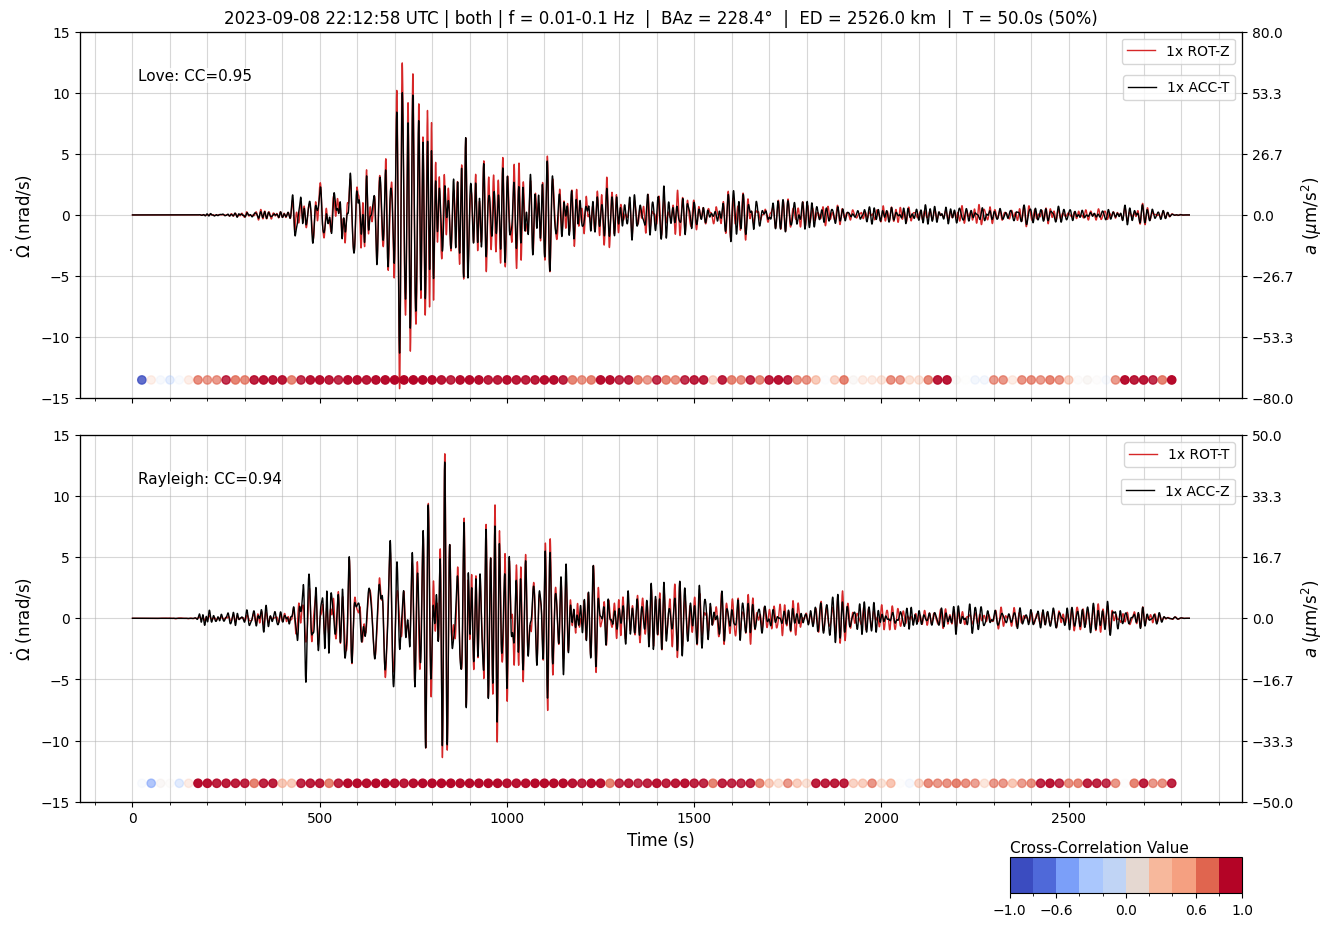

In [14]:
fig = plot_waveform_cc(
    sd_object=sd,
    twin_sec=params['twin_sec'],
    twin_overlap=params['twin_overlap'],
    wave_type="both" # "love" | "rayleigh" | "both"
)

Now we want to have a look at the spectral content of all six components to spot differences in translation and rotation data.

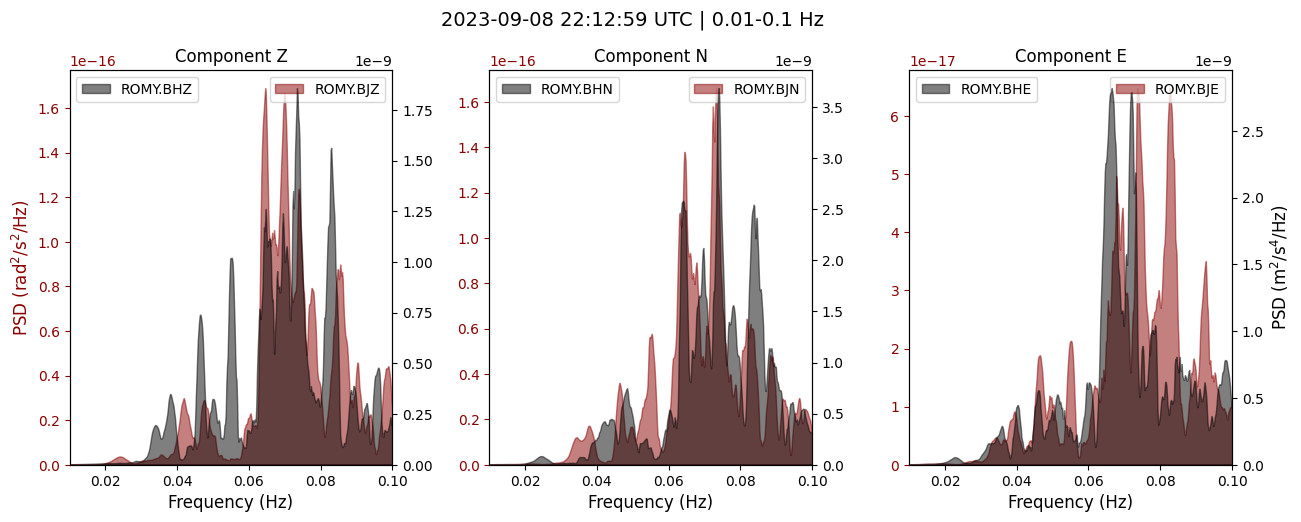

In [ ]:
fig = plot_spectra_comparison_fill(
    sd_object=sd,
    fmin=sd.fmin,
    fmax=sd.fmax,
    ylog=False,
    xlog=False, 
    fill=True # fill spectra
)

### Backazimuth Estimate

baz_max = 229, baz_std = 27


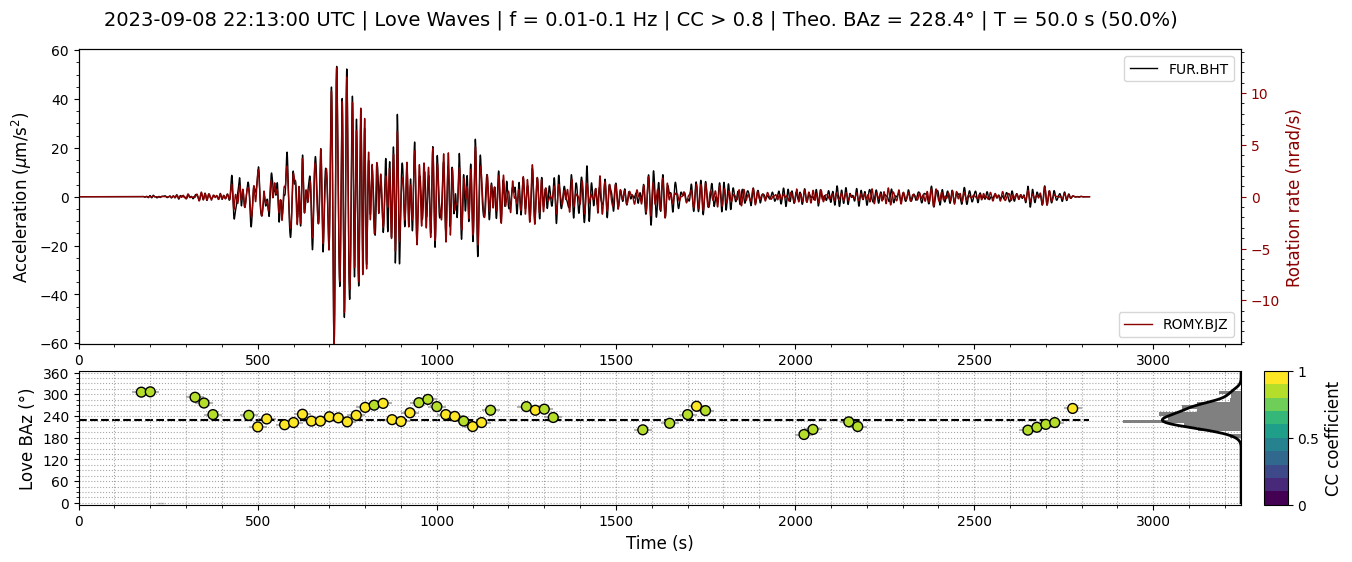

In [41]:
# First compute backazimuth
baz_results = sd.compute_backazimuth(
    wave_type='love',
    baz_step=params['baz_step'],
    baz_win_sec=params['twin_sec'],
    baz_win_overlap=params['twin_overlap'],
    out=True # output results
)

# Then plot results
fig = plot_backazimuth_results(
    sd,
    baz_results,
    wave_type='love',
    baz_theo=ev['backazimuth'],
    cc_threshold=params['cc_threshold']  # filter for cross-correlation coefficient threshold
)

baz_max = 231, baz_std = 15


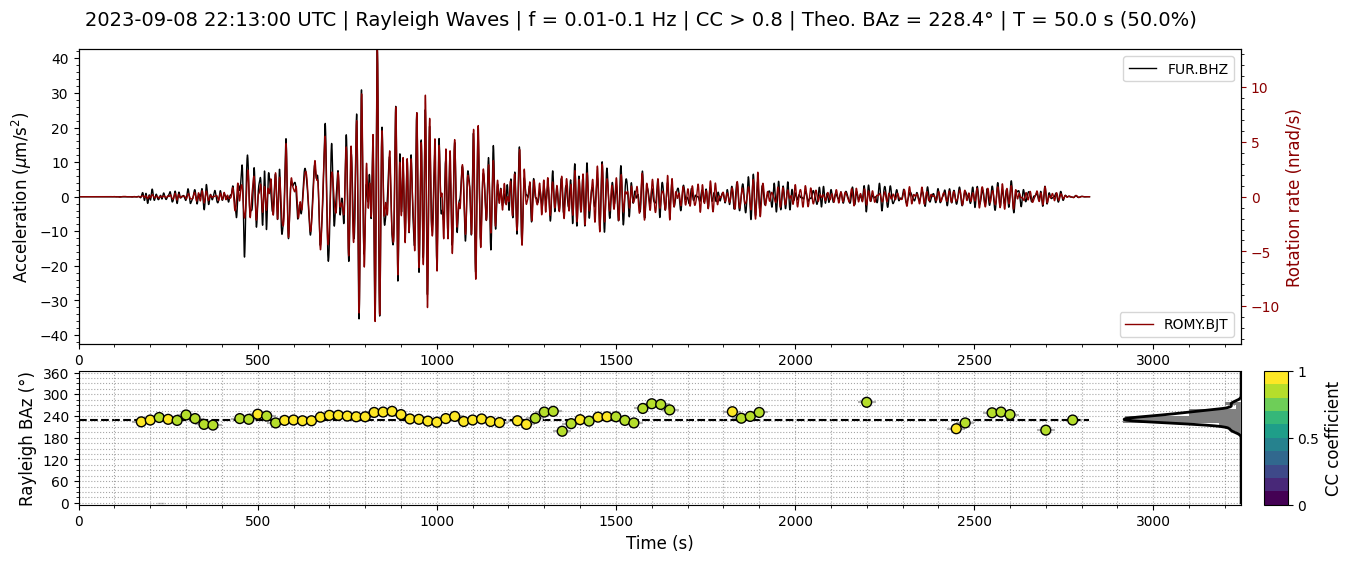

In [40]:
# First compute backazimuth
baz_results = sd.compute_backazimuth(
    wave_type='rayleigh',
    baz_step=params['baz_step'],
    baz_win_sec=params['twin_sec'],
    baz_win_overlap=params['twin_overlap'],
    out=True # output results
)

# Then plot results
fig = plot_backazimuth_results(
    sd,
    baz_results,
    wave_type='rayleigh',
    baz_theo=ev['backazimuth'],
    cc_threshold=params['cc_threshold']  # filter for cross-correlation coefficient threshold
)

Here we can compare all three possible backazimuth estimations.

Using precomputed love backazimuth results

Estimated BAZ Love = 238° (CC ≥ 0.8)
Using precomputed rayleigh backazimuth results

Estimated BAZ Rayleigh = 221° (CC ≥ 0.8)
Using precomputed tangent backazimuth results

Estimated BAZ Tangent = 236° (CC ≥ 0.8)


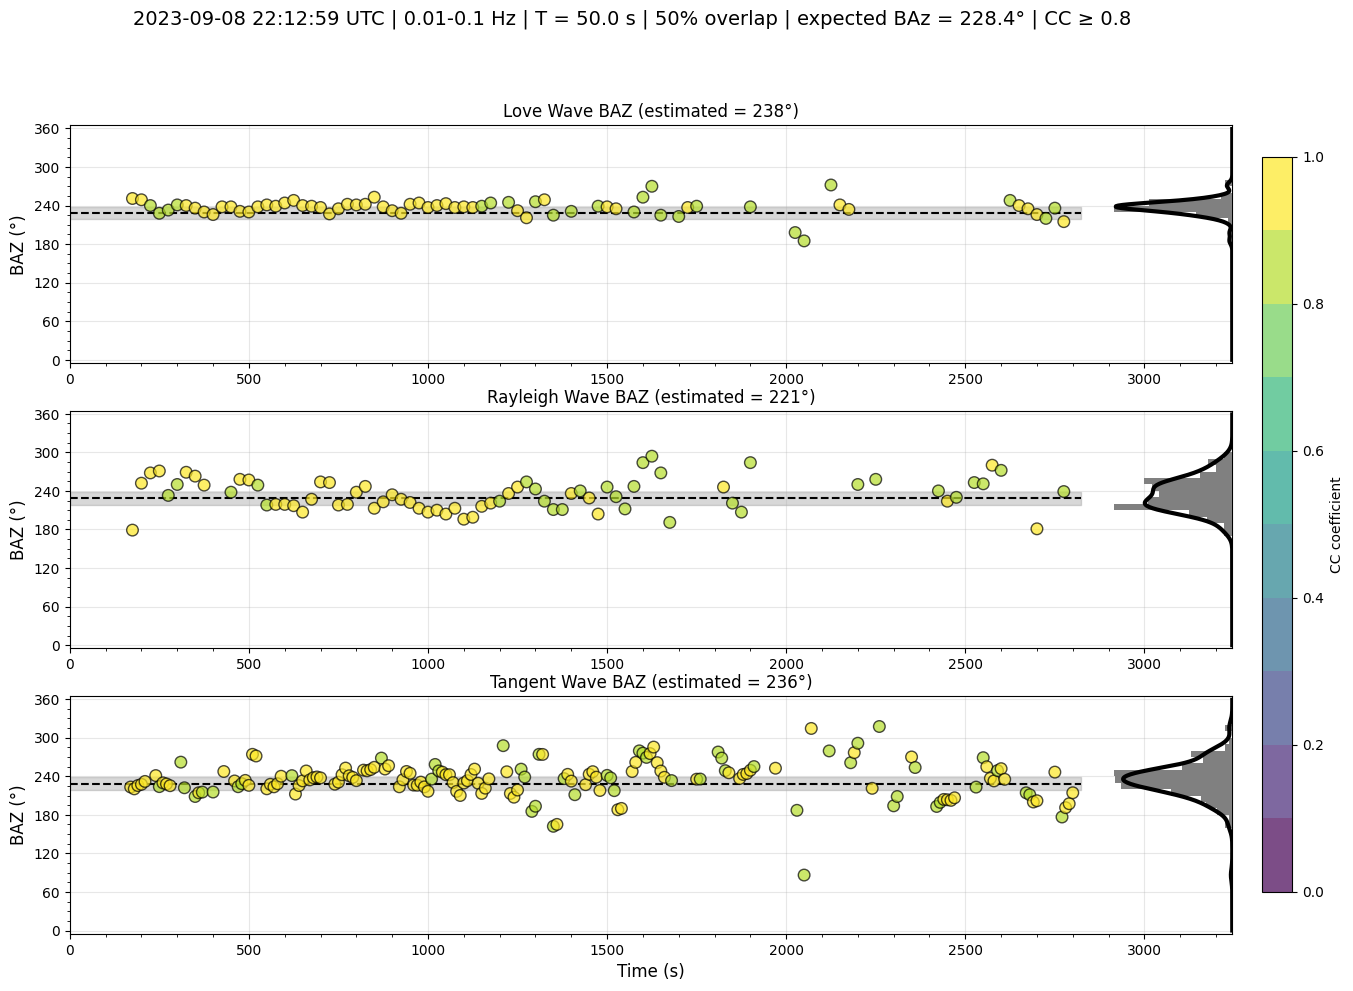

In [42]:
fig, results = sd.compare_backazimuth_methods(
    Twin=params['twin_sec'],
    Toverlap=params['twin_overlap'],
    cc_threshold=params['cc_threshold'],
    baz_theo=ev['backazimuth'],
    plot=True,
    output=True # output results
)

### Analyse Phase Velocities - Time Dependent

In [45]:
# Compute Love wave velocities
love_velocities = sd.compute_velocities(
    wave_type='love',
    win_time_s=params['twin_sec'],
    overlap=params['twin_overlap'],
    cc_threshold=params['cc_threshold'],
    method='odr',
    # baz=ev['backazimuth']  # optional
)

# Compute Rayleigh wave velocities
rayleigh_velocities = sd.compute_velocities(
    wave_type='rayleigh',
    win_time_s=params['twin_sec'],
    overlap=params['twin_overlap'],
    cc_threshold=params['cc_threshold'],
    method='odr', # "odr" | "ransac"
    # baz=ev['backazimuth']  # optional
)

Using event BAZ 228.4
Using event BAZ 228.4


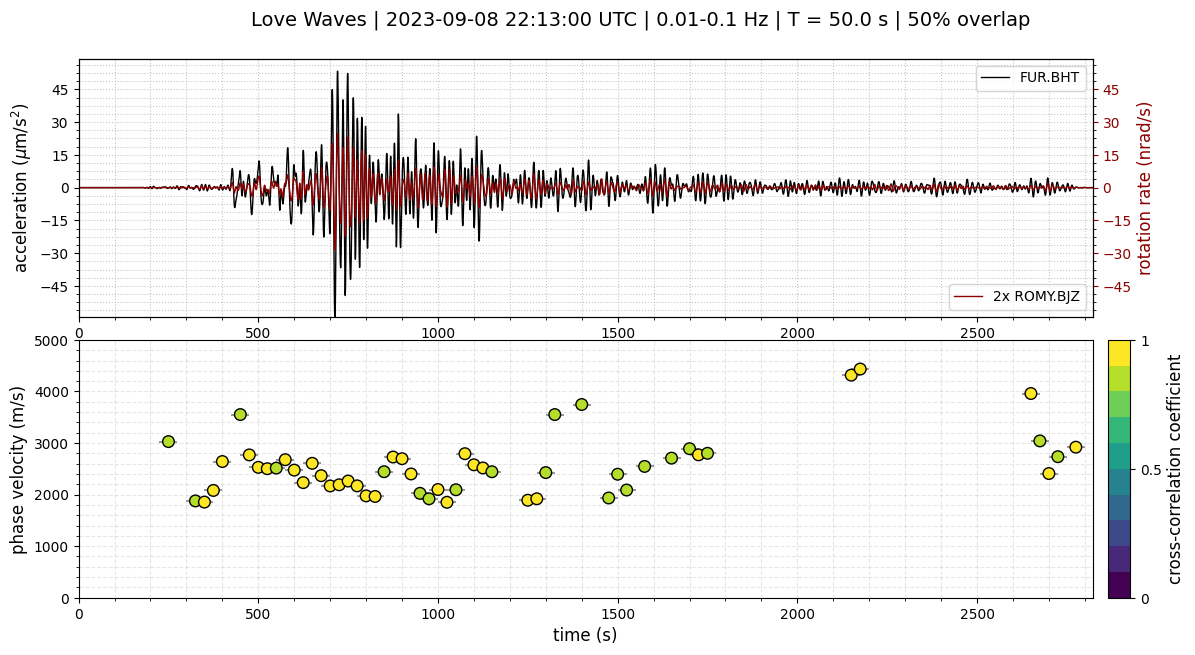

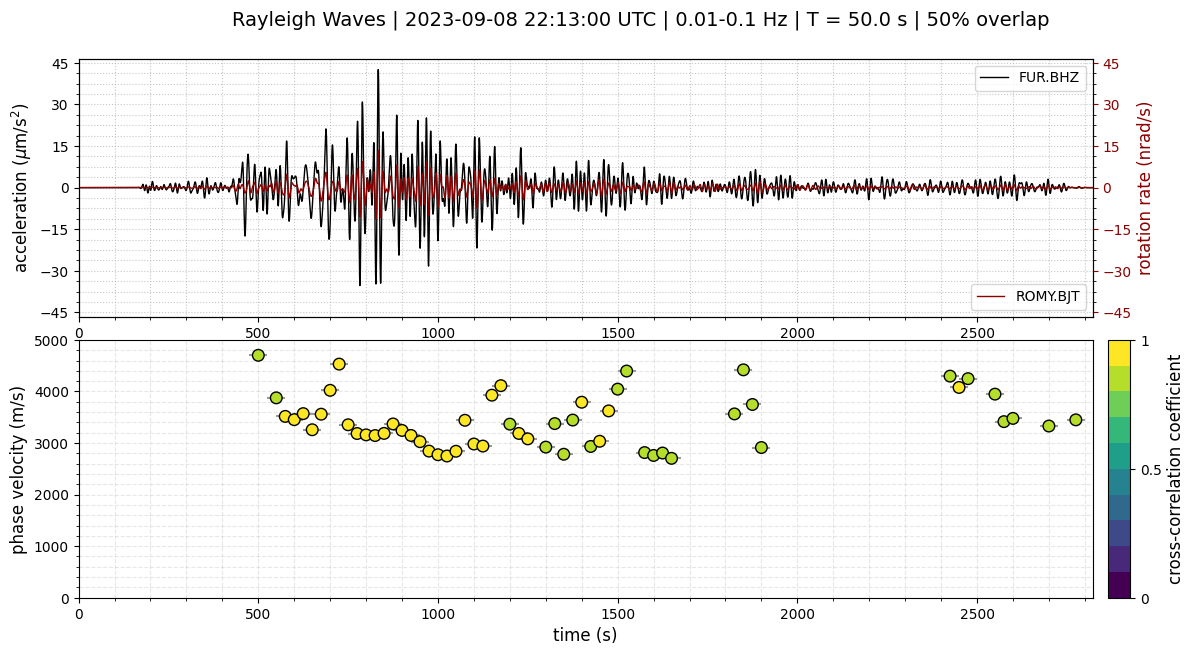

In [46]:
# Plot results
fig = plot_velocities(
    sd,
    velocity_results=love_velocities,
    vmax=5000,  # optional
    minors=True, # optional
    figsize=(15, 7)
)

# Plot results
fig = plot_velocities(
    sd,
    velocity_results=rayleigh_velocities,
    vmax=5000,  # optional
    minors=True, # optional
    figsize=(15, 7)
)

### Analyse Phase Velocity - Frequency Dependent

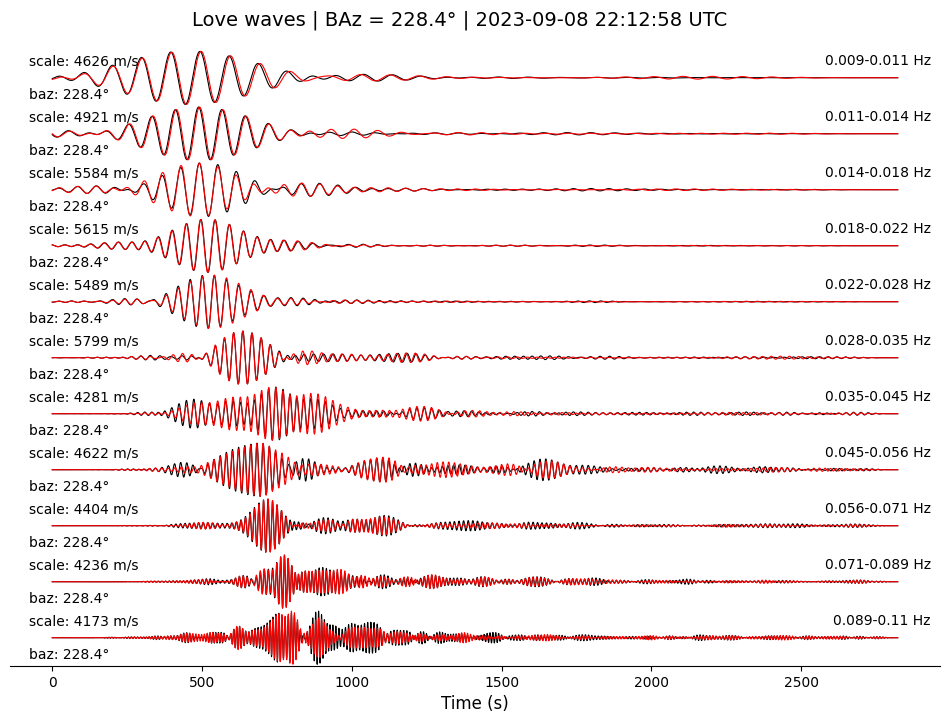

In [37]:
fig, disp_love = plot_trace_dispersion(
    sd_object=sd,
    wave_type="love", # "love" | "rayleigh"
    fmin=0.01,
    fmax=0.1,
    fraction_of_octave=3,
    figsize=(12, 8),
    output=True, # output results
    optimized=False # find an optimized backazimuth
)
